# Саобраћајне незгода на територији града Београда

Да ли се саобраћајне незгоде догађају чешће ноћу или дању, викендом или радним данима, на специјалним локацијама? 
На ова и многа друга питања понудићемо неке од одговора у експлоративној анализи сета података о саобраћајним незгодама. Подаци су прикупљени од стране Министарства унутрашњих послова Републике Србије, а преузели смо их са платформе отворених података (http://data.gov.rs/). 
У наставку ћемо:
- анализирати типове саобраћајних незгода које МУП бележи и направити одговарајуће стубичасте дијаграме
- визуелизоваћемо саобраћајне незгоде на мапи града Београда
- идентификоваћемо типичне периоде дана у току којих се дешавају саобраћајне незгоде и нацртаћемо одговарајуће визуелизације
- анализираћемо детаљније дане током којих се догодило значајно више незгода

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

Подаци са незгодама на територији Србије су доступни у целости за 2016, 2017 и 2018 годину и њих смо преузели и сачували у .csv формату (оригинални фајлови [на платформи](https://data.gov.rs/sr/datasets/podatsi-o-saobratshajnim-nezgodama-za-teritoriju-grada-beograda/) дати су у .odt формату и осим екстензије нису мењани). Учитаћемо сва три фајла на стандардан начин, а затим ћемо уз помоћ функције [**concat**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) надовезати ове табеле у једну заједничку:

In [2]:
data2016=pd.read_csv('data/sn data/NEZ_OPENDATA_2016_20170214.csv',header=None)
data2017=pd.read_csv('data/sn data/NEZ_OPENDATA_2017_20180129.csv',header=None)
data2018=pd.read_csv('data/sn data/NEZ_OPENDATA_2018_20190125.csv',header=None)
data_saobracajke=pd.concat([data2016,data2017,data2018])
data_saobracajke.head(2)

0                 1          2          3               4  \
0  1119231  01.01.2016,00:00  20.695308  44.447707  Sa povredjenim   
1  1115860  01.01.2016,01:30  20.466890  44.816650   Sa mat.stetom   

                           5  \
0             SN SA PE?ACIMA   
1  SN SA PARKIRANIM VOZILIMA   

                                                   6  
0  Pe?ak se kre?e du? kolovoza u smeru kretanja v...  
1  Sudar sa parkiranim vozilom sa desne strane ko...

Да проверимо да се и подаци из 2018 године налазе у табели *data_saobracajke*, проверићемо функцијом [**tail**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) последње редове:

In [3]:
data_saobracajke.tail(2)

0                 1          2          3               4  \
18061  1240797  31.12.2018,10:50  20.458234  44.813082   Sa mat.stetom   
18062  1240913  31.12.2018,21:30  20.349952  44.802480  Sa povredjenim   

                                               5  \
18061  SN SA NAJMANjE DVA VOZILA ? BEZ SKRETANjA   
18062  SN SA NAJMANjE DVA VOZILA ? BEZ SKRETANjA   

                                                       6  
18061  Najmanje dva vozila koja se kre?u u istom smer...  
18062  Ostale nezgode sa najmanje dva vozila ? suprot...

Како ове табеле не садрже називе колона, искористили смо додатни аргумент *header* у досада већ коришћеној **read_csv** функцији. То значи да је сада неопходно преименовати колоне и елиминисати оне које су нам непотребне (колону са тренутним називом 0 зато што је у њој вероватно неки индекс који нам се не чини корисним):

In [4]:
data_saobracajke.drop(columns=0, inplace=True)
data_saobracajke = data_saobracajke.rename(columns={1:'Datum i vreme',2:'Longitude',3:'Latitude',4:'Ishod',5:'Tip',6:'Komentar'})
data_saobracajke.head(2)

Datum i vreme  Longitude   Latitude           Ishod  \
0  01.01.2016,00:00  20.695308  44.447707  Sa povredjenim   
1  01.01.2016,01:30  20.466890  44.816650   Sa mat.stetom   

                         Tip  \
0             SN SA PE?ACIMA   
1  SN SA PARKIRANIM VOZILIMA   

                                            Komentar  
0  Pe?ak se kre?e du? kolovoza u smeru kretanja v...  
1  Sudar sa parkiranim vozilom sa desne strane ko...

Брисање колоне смо извели функцијом [**drop**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) док смо нова имена колона увели функцијом [**rename**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html), сада ћемо поглеади како су препознати типови података у овим колонама ([**info**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)) и евентуално извршити корекцију ако нешто није у складу са нашим очекивањима:

In [5]:
data_saobracajke.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53298 entries, 0 to 18062
Data columns (total 6 columns):
Datum i vreme    53298 non-null object
Longitude        53298 non-null float64
Latitude         53298 non-null float64
Ishod            53298 non-null object
Tip              53298 non-null object
Komentar         53298 non-null object
dtypes: float64(2), object(4)
memory usage: 2.8+ MB


Видимо да колона која садржи податке о датуму и времену није препозната на одговарајући начин, стога ћемо функцијом [**to_datetime**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) то кориговати зарад лакшег баратања временским одредницама:

In [6]:
data_saobracajke['Datum i vreme'] = pd.to_datetime(data_saobracajke['Datum i vreme'])
data_saobracajke.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53298 entries, 0 to 18062
Data columns (total 6 columns):
Datum i vreme    53298 non-null datetime64[ns]
Longitude        53298 non-null float64
Latitude         53298 non-null float64
Ishod            53298 non-null object
Tip              53298 non-null object
Komentar         53298 non-null object
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.8+ MB


Истражићемо додатно колоне о типу незгоде и исходу уз помоћ функција [**unique**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.unique.html) (да видимо који су различити уноси који постоје), а користећи функцију [**value_counts**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html) избројаћемо колико пута се сваки од уноса појављује у подацима.

In [7]:
data_saobracajke['Tip'].unique()

array(['SN SA PE?ACIMA', 'SN SA PARKIRANIM VOZILIMA',
       'SN SA JEDNIM VOZILOM',
       'SN SA NAJMANjE DVA VOZILA ? BEZ SKRETANjA',
       'SN SA NAJMANjE DVA VOZILA ? SKRETANjE ILI PRELAZAK'], dtype=object)

Можемо једноставно исправити грешке које су проузроковале '?' у типовима користећи функцију [**replace**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html):

In [8]:
data_saobracajke = data_saobracajke.replace({'Tip':{'SN SA PE?ACIMA':'SN SA PEŠACIMA',
                                                    'SN SA NAJMANjE DVA VOZILA ? BEZ SKRETANjA':'SN SA NAJMANjE DVA VOZILA - BEZ SKRETANjA',
                                                    'SN SA NAJMANjE DVA VOZILA ? SKRETANjE ILI PRELAZAK':'SN SA NAJMANjE DVA VOZILA - SKRETANjE ILI PRELAZAK'
                                                   }})

In [9]:
nezgode_po_tipu = data_saobracajke.Tip.value_counts()
nezgode_po_tipu

SN SA NAJMANjE DVA VOZILA - BEZ SKRETANjA             20419
SN SA NAJMANjE DVA VOZILA - SKRETANjE ILI PRELAZAK    13638
SN SA PARKIRANIM VOZILIMA                              9146
SN SA JEDNIM VOZILOM                                   6836
SN SA PEŠACIMA                                         3259
Name: Tip, dtype: int64

Ове податке можемо предтавити и хоризонталним стубичастим дијаграмом:

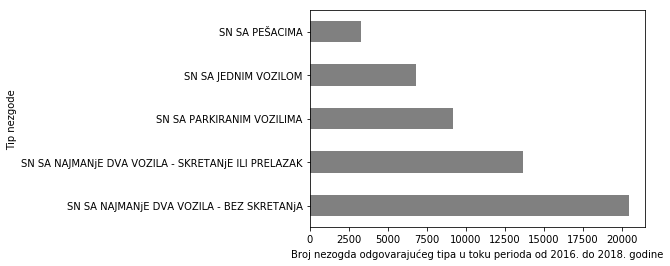

In [10]:
nezgode_po_tipu.plot(kind='barh',color='grey')
plt.ylabel('Tip nezgode')
plt.xlabel('Broj nezogda odgovarajućeg tipa u toku perioda od 2016. do 2018. godine')
plt.show()

Искористили смо овде функцију цртања графика [**plot**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) у оквиру *pandas* библиотеке, што је умањило број команди за обележавање назива различитих стубића. Као и раније када смо користили ову функцију, морали смо да проследимо и аргумент *kind* да дефинишемо тип графика, у овом случају хоризонтални стубичасти дијаграм (*barh*) зарад лакшег читања назива стубића.

Видимо да су незгоде које укључују пешаке најређе, док се најчешће дешавају незгоде које укључују два возила и не укључују скретања или престројавања.

А можемо израчунати и процентуалну заступљеност свих незгода па на х-оси користити ту вредносту уместо укупног броја незгода:

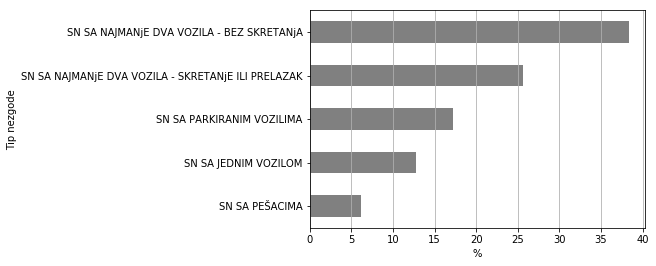

In [11]:
nezgode_po_tipu_procenti = (100*nezgode_po_tipu/nezgode_po_tipu.sum()).sort_values()
nezgode_po_tipu_procenti.plot(kind='barh',color='grey')
plt.ylabel('Tip nezgode')
plt.xlabel('%')
plt.grid(axis='x')
plt.show()

Овде смо још додатно сортирали табелу пре цртања, тако да су типови поређани од најчешћег до најређег. Такође, функцијом [**grid**](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.grid.html) додали смо вертикалне линије да олакшају очитавање података са графика - незгоде са најмање два возила чине преко 60% незгода!

Слично можемо истражити који све исходи саобраћајних незгода су наведени у табели и колико често су се дешавали у посматраном периоду:

In [12]:
data_saobracajke['Ishod'].unique()

array(['Sa povredjenim', 'Sa mat.stetom', 'Sa poginulim'], dtype=object)

На исти начин као и претходно избројте колико често се сваки од ових исхода догађао у периоду од 3 године и податке представите хоризонталним стубичастим дијаграмом:

In [13]:
#место за ваш код

## Где се дешавају саобраћајне незгоде?

Користећи библиотеку *plotly.express* и функцију [**scatter_mapbox**](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html) можемо тачкастим дијаграмом представити све саобраћајне незгоде из посматраног периода на мапи Београдa. Пробајте прво верзију кода у наставку, а затим пробајте искоментарисану линију која ће мало побољшати мапу:

In [14]:
Belgrade_center = {'lat':44.787197,'lon':20.457273}
fig = px.scatter_mapbox(data_saobracajke, lat="Latitude", lon="Longitude") #базична верзија
#fig = px.scatter_mapbox(data_saobracajke, lat="Latitude", lon="Longitude", opacity=0.5, zoom=10,center=Belgrade_center) #центрирана и зумирана мапа са транспарентнијим кружићима
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Међутим, број саобраћајних незгода које су садржане у овом сету података (који је то број?) је изузетно велики да бисмо податке само овако представили на мапи и могли да закључимо нешто. Гледајући само овај график, једино што можемо да кажемо на питање где се дешавају саобраћајне несреће је - дуж улица - што признаћете није баш закључак за који нам је требала анализа података.

*Зумирајте мапу (користећи zoom in/out команде које се појављују у горњем десном углу ове интерактивне визуализације) да видите делове града који вас можда посебно занимају.*

Да бисмо у овој гужви тачкица могли да видимо више и препознамо неке специфичне ефекте, можемо пробати да представимо мање података, на пример податке у току само једног месеца, или да бојимо тачкице по типу или исходу незгоде. Један бенефит трансформације колоне о датуму и времену незгоде у *datetime* тип података је што сада једноставно можемо из колоне издвојити сат, дан, месец или годину кад нам то затреба:

In [15]:
data_to_plot = data_saobracajke[data_saobracajke['Datum i vreme'].dt.month==7]
fig = px.scatter_mapbox(data_to_plot, lat='Latitude', lon='Longitude',color='Ishod', zoom=10)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Овај интерактивни метод визуализације података на мапи даје нам могућност и да кликом на одређене категорије у легенди фокусирамо представљене податке на само један тип или да представимо више типова који нас занимају. Овако можемо врло брзо добити мапу са само једним типом незгода или исходом, без селектовања података пре цртања.
Међутим, иако је ова мапа (са незгодама током једног месеца и једним исходом) мање преплављена тачкицама, избори које смо направили да смањимо број тачака су арбитрарни. Али и са смањеним бројем тачака, оне су расуте широм града и није јасно да ли можемо да закључимо нешто посматрајући ову мапу. Још једном, оно што нам недостаје је контекст, неке референтне вредности у односу на које можемо да закључимо да ли постоје локације на којима се дешава велики број незгода а што није само последица велике прометности улице. 

Можда нам временска компонента ових података помогне да смислено издвојимо неке специфичне периоде, па онда можемо мало мањи сет представити на мапи и анализирати. Пре него што се упустимо у временску анализу, искоментарисани код је још један начин за представљање података на мапи, испробајте и ову функцију [**density_mapbox**](https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox.html):

In [16]:
# fig = px.density_mapbox(data_to_plot, lat='Latitude', lon='Longitude', zoom=10)
# fig.update_layout(mapbox_style='open-street-map')
# fig.show()

## Када се саобраћајне незгоде дешавају?

У наставку ћемо истражити како се број незгода које се дешавају мења из дана у дан, да ли постоје неки дани током којих је број несрећа био изразито велик, да ли постоје периоди дана када су незгоде чешће и слично.

Број незгода по дану можемо израчунати на више начина, на пример тако што ћемо искористити функцију **hist** која ће извршити фреквенцијску анализу, али како смо то радили више пута, овде ћемо погледати како то исто урадити групишући податке по години, месецу и дану (**groupby**) и бројећи незгоде у сваком од дана (**size**). Када имамо дуже временске серије, обично је згодно "развући" график по х оси што контролишемо дефинисањем димензија слике *figsize*.

In [17]:
nezgodepodanu = pd.DataFrame(data_saobracajke.groupby([data_saobracajke['Datum i vreme'].dt.year,data_saobracajke['Datum i vreme'].dt.month,data_saobracajke['Datum i vreme'].dt.day]).size())
nezgodepodanu.plot(figsize=(18,3),color='grey')
plt.xlabel('Datum')
plt.ylabel('Broj saobraćajnih nezgoda u datom danu')
plt.legend('')
plt.show()

Направили смо нову табелу у којој су смештени укупни бројеви саобраћајних незгода за сваки од дана у току посматране 3 године. Видимо да број незгода који се догађа доста осцилује - постоје дани у којима се дешавало и мање од 10 несрећа, али постоје и они са преко 70-80 несрећа!
Да бисмо видели колико често има 10ак незгода, а колико незгода има у типичном дану, можемо погледати хистограм ове нове табеле:

In [18]:
nezgodepodanu.head(2)

0
Datum i vreme Datum i vreme Datum i vreme    
2016          1             1              28
                            2              38

Преименоваћемо колону у којој су резултати бројања:

In [19]:
nezgodepodanu = nezgodepodanu.rename(columns={0:'Broj SN'})

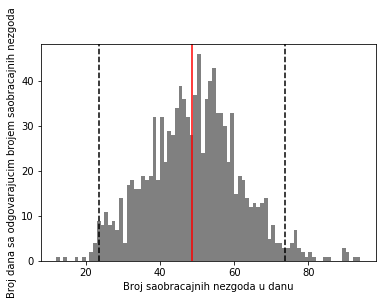

In [20]:
plt.hist(nezgodepodanu['Broj SN'],bins=range(min(nezgodepodanu['Broj SN']),max(nezgodepodanu['Broj SN'])+1,1),color='grey')
plt.xlabel('Broj saobracajnih nezgoda u danu')
plt.ylabel('Broj dana sa odgovarajucim brojem saobracajnih nezgoda')

# овде рачунамо просечну вредност и стандардну девијацију
m = np.mean(nezgodepodanu['Broj SN'])
s = np.std(nezgodepodanu['Broj SN'])
# овде цртамо вертикалне линије да означимо ове вредности
plt.axvline(x=m,color='red')
plt.axvline(x=m+2*s,color='black',linestyle='dashed')
plt.axvline(x=m-2*s,color='black',linestyle='dashed')

plt.show()

На хистограм смо унели и линије које означавају просечну вредност броја незгода по дану као и две вертикалне линије које су од дате просечне вредности удаљене за 2 стандардне девијације. (Просечну вредност и страндардну девијацију израчунали смо користећи функције **mean** и **std** библиотеке *numpy*.)
Када податке моделујемо нормалном расподелом, за шта је овај график можда најбољи пример у досадашњој анализи), интервал у оквиру 2 стандардне девијације је интервал у коме се налази 95% резултата (подаци оивичени усправним црним линијама). Mожемо проверити да ли то важи у овом случају:

In [21]:
100*len(nezgodepodanu[(nezgodepodanu['Broj SN']>=m-2*s)&(nezgodepodanu['Broj SN']<=m+2*s)])/len(nezgodepodanu)

95.34671532846716

А у оквиру 3 стандардне девијације налази се:

In [22]:
100*len(nezgodepodanu[(nezgodepodanu['Broj SN']>=m-3*s)&(nezgodepodanu['Broj SN']<=m+3*s)])/len(nezgodepodanu)

99.36131386861314

процената података.

Хајде да видимо током којих дана се десило највише незгода, тј. који су то дани када је било и за три стандардне девијације више незгода него просечног дана (таквих дана има мање од 0.5%):

In [23]:
nezgodepodanu[nezgodepodanu['Broj SN']>m+3*s]

Broj SN
Datum i vreme Datum i vreme Datum i vreme         
2017          1             25                  94
              7             12                  89
              11            9                   90
                            15                  89
2018          2             26                  92
              3             22                  89
              12            14                  90

Видимо да су се ови рекодрни дани дешавали махом крајем или почетком године (новембар-март) када и временске непогоде могу бити значајни узрочници, а видимо само један летњи дан - 12. јул.
Хајде да видимо да ли је нешто специфично у вези са несрећама током ових дана, да ли се овај велики број незгода дешавао на сличном месту или у слично време.
Издвојили смо у табелу *rekordnidan* податке за датум када је било највише незгода - 94, међутим ако ваш интригира неки други дан, промените дан, месец и годину у услову:

In [24]:
uslov = (data_saobracajke['Datum i vreme'].dt.year==2017)&(data_saobracajke['Datum i vreme'].dt.month==1)&(data_saobracajke['Datum i vreme'].dt.day==25)
rekordnidan = data_saobracajke[uslov]

Погледајмо број незгода у току сваког сата:

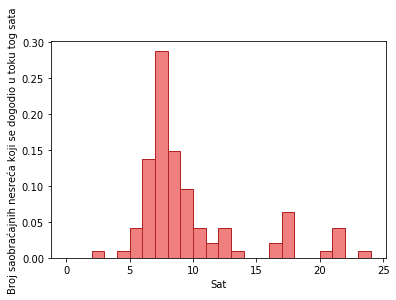

In [25]:
plt.hist(rekordnidan['Datum i vreme'].dt.hour,bins=range(0,25,1),color='lightcoral',edgecolor='firebrick',density=True)
plt.xlabel('Sat')
plt.ylabel('Broj saobraćajnih nesreća koji se dogodio u toku tog sata')
plt.show()

Додали смо неке претходно ређе коришћене опције на овом хистограму - мењали смо не само боју правоугаоника већ и ивица да бисмо лакше визуелно раздвојили све стубиће. Али, битнија измена коју смо направили настала је опцијом *density* - на у оси се не налазе укупни бројеви несрећа у сваком сату, већ однос између овог броја и свих несрећа у посматраном дану.

Видимо да се изузетно велики број незгода догодио у јутарњим сатима, али не знамо да ли је то тако и иначе, да ли се саобраћајне незгоде увек дешавају у преподневним сатима у овом броју? 
Као и обично, да бисмо оценили неки број или неку расподелу бројева потребан нам је контекст или неки други бројеви да упоредимо и разјаснимо да ли је ово што посматрамо очекивана ситуација или не.
Као природан кандидат за поређење намеће се укупна расподела броја незгода из сата у сат:

In [26]:
plt.hist(data_saobracajke['Datum i vreme'].dt.hour,bins=range(0,25,1),color='grey',alpha=0.5,edgecolor='darkgrey',density=True)
plt.xlabel('Sat')
plt.ylabel('Broj saobraćajnih nesreća koji se dogodio u toku tog sata')
plt.show()

Видимо да број незгода по сату има доста сличну структуру оној коју смо видели у анализи јавног градског превоза - постоји интервал у току ноћи када је град и самим тим превоз мање активан, а током активног дела дана број незгода је драстично већи - највише у поподневним сатима, након чега опада лагано до поноћи. 

Поређењем ова два графика, јасно нам да је рекордни дан другачији од просечног, не само по укупном броју незгода као што смо раније констатовали већ и по терминима када су се незгоде дешавале. Овим подацима узрок може бити у неким специфичним временским условима који су задесили Београд у преподневним часовима тог дана. Са друге стране, може бити по среди неки ланчани судар или нешто слично, стога хајде да погледамо и да ли су ове 94 незгоде груписане у простору:

In [27]:
fig = px.scatter_mapbox(rekordnidan, lat='Latitude', lon='Longitude',hover_name='Datum i vreme',zoom=10)
#fig = px.density_mapbox(rekordnidan, lat='Latitude', lon='Longitude',hover_name='Datum i vreme',zoom=10)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Међутим, визуелна оцена типичног или нетипичног понашања на мапи је значајно тежа од посматрања хистограма, те овако није јасно да ли су неки региони специфичнији од других. Потражите где су се незгоде дешавале у јутарњим сатима (додали смо и ту информацију да се појављује преласком преко забележених тачака незгоде). Можете такође испробати визуализацију истих података уз помоћ функције **density_mapbox** (та линија кода је у коментару).

Да бисмо на сличан начин као са временима оценили да ли током овог рекордног дана неки крај града специфичнији од других, исто ћемо упоредити два хистограма, овај пут дводимензионална. Један хистограм приказиваће број незгода по квадратићу просора на мапи за све несреће током посматраног периода, док ће други приказивати незгоде само током дана који анализирамо.
Као што смо поредећи хистограме по временима обезбедили да интервали у којима пребројавамо незгоде буду исти (у оба случаја сати у току дана), тако и сада морамо обезбедити исто. За почетак, ограничићемо опсег географске ширине и дужине коју разматрамо:

In [28]:
lat = [44.65,44.95]
long = [20.25,20.65]

In [29]:
data_to_plot = data_saobracajke[(data_saobracajke['Latitude']>lat[0])&(data_saobracajke['Latitude']<lat[1])&(data_saobracajke['Longitude']>long[0])&(data_saobracajke['Longitude']<long[1])]

Овим смо исекли посматрани сет података фокусирајући се на квадрат који садржи најактивнији сегмент града (и преко 90% незгода). Користећи **scatter_mapbox** и ове податке *data_to_plot* можете осмотрити колико смо се ограничили и ако желите проширите сегмент по било којој димензији - изменом lat, long варијабли.

Цео опсег по х оси ћемо поделити на 100 сегмената једнаке дужине и исто ћемо урадити за у осу (контролишући аргумент *bins*; у општем случају број сегмената на х и у оси може бити другачиији, тада бисте користили нпр. *bins* = [100,110]). Користећи функцију **hist2d** добићемо број незгода које су се догодиле у сваком од ових 100х100 четвороуглова који су настали. 

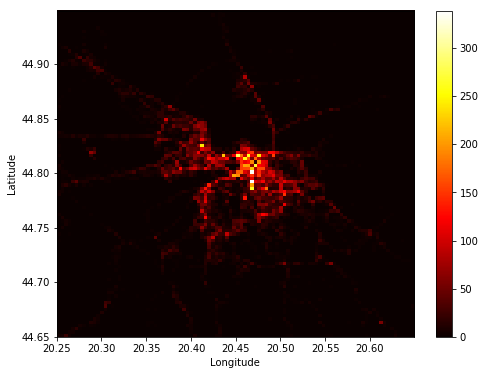

In [30]:
plt.figure(figsize=(8,6))
output = plt.hist2d(data_to_plot['Longitude'],data_to_plot['Latitude'],100,cmap='hot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

Можда сте већ приметили да смо овај пут функцију **hist2d** позвали на нешто необичнији начин ```output = plt.hist2d(...)```?
То је зато што нам ова функција (као и **hist**) поред графичкој оутпута, враћа и коодринате свих ових сегмената и број незгода у сваком од њих. Иако се ово стално дешава, тај оутпут нам углавном није био потребан па га нисмо додељивали некој новој варијабли, али како сада хоћемо да нацртамо још један хистограм користећи истих 100х100 правоугаоника, њихове позиције ћемо преузети из варијабле output. (Проверите шта је њен садржај!)

In [31]:
plt.hist2d(rekordnidan['Longitude'],rekordnidan['Latitude'],bins=[output[1],output[2]],cmap='hot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

На просторном хистограму незгода у току посматраног рекордног дана слабије видимо обрисе града зато што има далеко мање података (на горњем дијаграму можете прилично јасно видети где су реке, где је средиште града и слично). Међутим, видимо да регије у којима има највише незгода (иако је то само 2 или 3 незгоде) нису они у којима је целокупно посматрана мапа најсветлија. Moжда је то само ефекат малог броја незгода које посматрамо на великом простору?

Да бисмо тестирали и ту хипотезу, на наредној слици приказаћемо упоредно хистограм локација свих незгода које су се догодиле у току рекордног дана који посматрамо (лево) и насумично изабраних незгода из целог посматраног сета података *data_to_plot* (десно). Насумичне редове табеле добијамо функцијом [**sample**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) чији је аргумент број насумичних редова које желимо да добијемо - ту вредност смо поставили да буде једнака величини сета *rekordnidan*:

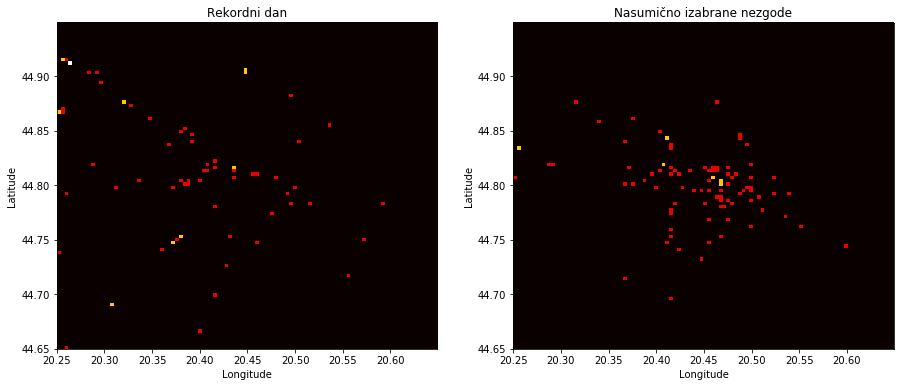

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.hist2d(rekordnidan['Longitude'],rekordnidan['Latitude'],bins=[output[1],output[2]],cmap='hot', vmin=0, vmax=3)
ax1.set_title('Rekordni dan')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

random_data = data_to_plot.sample(len(rekordnidan))
ax2.hist2d(random_data['Longitude'],random_data['Latitude'],bins=[output[1],output[2]],cmap='hot', vmin=0, vmax=3)
ax2.set_title('Nasumično izabrane nezgode')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.show()

Насумично генерисани подаци (покрените блок кода више пута да видите више различитих насумичних избора) сарже знатно више незгода у централним деловима града и ретко су присутна 'нагомилавања' 2 или 3 незгоде изван централних региона. Са друге стране, током рекордног дана највише незгода се десило баш на ободима - вратите се сада на визуелизацију ових података на мапи и идентификујте које су то улице или раскрснице где се у току рекордног дана догодило више незгода него што бисмо очекивали да се незгоде дешавају насумично (као што приказује десни график).

Поређење података са насумично генерисаним подацима је чест алат када је циљ да процените да ли се дешава нешто необично, или је у питању нешто што се лако може десити и сасвим случајно. Напреднији алати, као што су статистички тестови и процена статистичке значајности, за циљ имају управо ово што смо у овом примеру оцењивали визуелно - да проценимо колико је вероватно да је неки податак до кога смо дошли мерењем или истраживањем значајан, односно да се не може објаснити само насумичношћу. *Пробајте да покрећете последњи код више пута, баш исту слику као рекордног дана ћете добити врло врло ретко.*

## Задаци

1. Испитати да ли је број саобраћајних незгода исти сваким даном, или дан у недељи игра неку улогу (да ли има више незгода недељом или понедељком?) и представити резултат стубичастим дијаграмом.

2. Нацртајте три различита хистограма (један за сваки тип исхода незгоде) који приказују број саобраћајних незгода из сата у сат. Шта примећујете?

3. Испитати да ли је просечан број саобраћајних незгода по дану исти за све месеце. Представити резултате стубичастим дијаграмом и вертикалном линијом обележити годишњи просечан број саобраћајних незгода по дану. 

4. 

(а) Издвојити из података које смо до сада анализирали једну календарску годину (по избору) и саобраћајне незгоде са смртним исходима. Користећи функцију **scatter_mapbox** нацртати локације свих ових незгода на мапи, можете обојити тачкице на основу колоне тип.

    (б) Користећи *data_to_plot* издвојте све случајеве са смртним исходом и нацртајте дводимензионални хистограм користећи *output*, а затим упоредите са сетом (исте величине) насумично издвојених саобраћајних незгода. *Користите последњи блок кода за инспирацију.* Шта примећујете, идентификујте делове града код којих је број незгода са смртним иходом чешћи него случајно.

5. У међувремену су отворени и подаци на територији целе Србије, можете их преузети са [ове веб адресе](https://data.gov.rs/sr/datasets/podatsi-o-saobratshajnim-nezgodama-po-politsijskim-upravama-i-opshtinama/). Нацртајте мапу саобраћајних незгода на територији целе Србије за годину по избору.
Нацртајте линијски дијаграм на коме поредите број незгода по дану у првој половини 2020. године и у првој половини 2019. године. Да ли постоје последице пандемије корона вируса? 